# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Your Own Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, you will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. You will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. You will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

Before looking at the bike sharing data, you should start by asking questions you might want to understand about the bike share data. Consider, for example, if you were working for Motivate. What kinds of information would you want to know about in order to make smarter business decisions? If you were a user of the bike-share service, what factors might influence how you would want to use the service?

**Question 1**: Write at least two questions related to bike sharing that you think could be answered by data.

**Answer**: Bike sharing data could potentially be used in many GIS and non-GIS related fields. Depending upon the richness of the data following questions can be answered.

- What time of the weekday is the most usage? Is it during office rush hours or liesure bike ride over weekends?
- What kind of distances are covered? Straight or with more twists and turns?
- Which neighbourhoods have the highest amount of users and what are the characteristics of users in terms of age, education, occupation etc.?
- How do the routes taken by users compare to public transport (un)availability and/or status?
- Live data about routes and changes in the route given circumstances can be useful to train routing algorithms.

<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If you visit these pages, you will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly. **However, you do not need to download the data yourself.** The data has already been collected for you in the `/data/` folder of the project files. While the original data for 2016 is spread among multiple files for each city, the files in the `/data/` folder collect all of the trip data for the year into one file per city. Some data wrangling of inconsistencies in timestamp format within each city has already been performed for you. In addition, a random 2% sample of the original data is taken to make the exploration more manageable. 

**Question 2**: However, there is still a lot of data for us to investigate, so it's a good idea to start off by looking at one entry from each of the cities we're going to analyze. Run the first code cell below to load some packages and functions that you'll be using in your analysis. Then, complete the second code cell to print out the first trip recorded from each of the cities (the second line of each data file).

In [1]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.

In [2]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """

    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))

    with open(filename, 'r') as f_in:
        trip_reader = csv.DictReader(f_in)
        first_trip = next(trip_reader) # accessing the first trip with next method
        pprint(first_trip) # pretty printing the dict

    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv']

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

If everything has been filled out correctly, you should see below the printout of each city name (which has been parsed from the data file name) that the first trip has been parsed in the form of a dictionary. When you set up a `DictReader` object, the first row of the data file is normally interpreted as column names. Every other row in the data file will use those column names as keys, as a dictionary is generated for each row.

This will be useful since we can refer to quantities by an easily-understandable label instead of just a numeric index. For example, if we have a trip stored in the variable `row`, then we would rather get the trip duration from `row['duration']` instead of `row[0]`.

<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

You will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, you will convert the Washington labels to match the other two.


**Question 3a**: Complete the helper functions in the code cells below to address each of the cleaning tasks described above.

In [3]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    """
    
    duration = 0
    if city == 'Washington':
        duration = float(datum['Duration (ms)'])
        return duration / 60000  # ms to minutes
    else:
        duration = float(datum['tripduration'])  # str to float
        return duration / 60  # seconds to minutes

# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [4]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.
    
    HINT: You should use the datetime module to parse the original date
    strings into a format that is useful for extracting the desired information.
    see https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    """
    if city == 'Washington':
        # convert the 'Start date' for washington to datetime_object
        dt_object = datetime.strptime(datum['Start date'], "%m/%d/%Y %H:%M")
        month = int(dt_object.strftime('%m')) # extract month
        hour = int(dt_object.strftime('%H')) # extract hour
        day_of_week = dt_object.strftime('%A') # extract day of the week

        return (month, hour, day_of_week)

    elif city == 'NYC':
        # convert the starttime for NYC to datetime_object taking the seconds into account
        dt_object = datetime.strptime(datum['starttime'], "%m/%d/%Y %H:%M:%S")
        month = int(dt_object.strftime('%m'))  # extract month
        hour = int(dt_object.strftime('%H'))  # extract hour
        day_of_week = dt_object.strftime('%A')  # extract day of the week

        return (month, hour, day_of_week)

    else:
        dt_object = datetime.strptime(datum['starttime'], "%m/%d/%Y %H:%M")
        month = int(dt_object.strftime('%m'))  # extract month
        hour = int(dt_object.strftime('%H'))  # extract hour
        day_of_week = dt_object.strftime('%A')  # extract day of the week

        return (month, hour, day_of_week)


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [5]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """
    
    if city == 'Washington':
        # accounting for different naming convention for Washington
        user_type = datum['Member Type']
         # standardizing the naming according to other cities
        if user_type == 'Registered':
            user_type = 'Subscriber'
        else:
            user_type = 'Customer'
        return user_type
    else:
        user_type = datum['usertype']
        return user_type
    
# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

**Question 3b**: Now, use the helper functions you wrote above to create a condensed data file for each city consisting only of the data fields indicated above. In the `/examples/` folder, you will see an example datafile from the [Bay Area Bike Share](http://www.bayareabikeshare.com/open-data) before and after conversion. Make sure that your output is formatted to be consistent with the example file.

In [6]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    """

    with open(out_file, 'w', newline="\n") as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']
        trip_writer = csv.DictWriter(f_out, fieldnames=out_colnames)
        trip_writer.writeheader()

        # set up csv DictReader object 
        trip_reader = csv.DictReader(f_in)


        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}

            # extracting info from helper functions and writing them to outputfile
            new_point['duration'] = duration_in_mins(row, city)
            # following three lines are necessary because time_of_trip function returns a tuple
            new_point['month'] = time_of_trip(row, city)[0]
            new_point['hour'] = time_of_trip(row, city)[1]
            new_point['day_of_week'] = time_of_trip(row, city)[2]
            new_point['user_type'] = type_of_user(row, city)

            # write the processed information to the output file
            trip_writer.writerow(new_point)

In [7]:
# Run this cell to check your work
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now that you have the data collected and wrangled, you're ready to start exploring the data. In this section you will write some code to compute descriptive statistics from the data. You will also be introduced to the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. The second cell runs this function on the example Bay Area data in the `/examples/` folder. Modify the cells to answer the question below.

**Question 4a**: Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?

**Answer**: 
- New York City has the highest number of **total trips**: 276798
- Similarly, New York City aces in the proportion of trips made by **subscribers: 88.83%** of the trips were made by subscribers!
- However, Chicago saw highest number of ad-hoc **customer rides** in proportion: **23.77%**

In [8]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_total)

In [9]:
## Modify this and the previous cell to answer Question 4a. Remember to run ##
## the function on the cleaned data files you created from Question 3.      ##

data_file = './data/NYC-2016-Summary.csv'
print(number_of_trips(data_file))

(245896, 30902, 276798)


**Question 4b**: Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

**Answer**: function below **trip_length_stat** computes and gives following statistics!
- average trip length for NYC is: 15.81 minutes
- proportion of rides longer than 30 minutes in NYC is: 7.30%
- average trip length for Chicago is: 16.56 minutes
- proportion of rides longer than 30 minutes in Chicago is: 8.33%
- average trip length for Washington is: 18.93 minutes
- proportion of rides longer than 30 minutes in Washington is: 10.84%

In [10]:
def trip_length_stat(infile_csv):
    """
    Takes in a csv file and gives out average ride duration and 
    proportion of rides greater than 30 mins in percentage
    
    input param: csv file
    output param: tuple
    """
    durations = []
    
    # read from input file
    with open(infile_csv, 'r') as f_in:
        filereader = csv.DictReader(f_in)
        for row in filereader:
            durations.append(float(row['duration']))
    
    # compute total rides and average ride duration
    total_rides = len(durations)
    avg_ride_duration = sum(durations) / total_rides
    
    # compute rides greater than 30 mins followed by proportion
    n_gt_30_mins = len([time for time in durations if time > 30])
    proportion_gt_30_mins = 100*n_gt_30_mins/total_rides

    return avg_ride_duration, proportion_gt_30_mins


summary_files = ['./data/NYC-2016-Summary.csv',
                 './data/Chicago-2016-Summary.csv',
                 './data/Washington-2016-Summary.csv']

for file in summary_files:
    avg_duration = trip_length_stat(file)[0]
    gt_30_mins = trip_length_stat(file)[1]
    city = file.split('-')[0].split('/')[-1]
    print('average trip length for {} is: {:.2f} minutes'.format(city,avg_duration))
    print('proportion of rides longer than 30 minutes in {} is: {:.2f}%'.format(city, gt_30_mins))

average trip length for NYC is: 15.81 minutes
proportion of rides longer than 30 minutes in NYC is: 7.30%
average trip length for Chicago is: 16.56 minutes
proportion of rides longer than 30 minutes in Chicago is: 8.33%
average trip length for Washington is: 18.93 minutes
proportion of rides longer than 30 minutes in Washington is: 10.84%


**Question 4c**: Dig deeper into the question of trip duration based on ridership. Choose one city. Within that city, which type of user takes longer rides on average: Subscribers or Customers?

**Answer**: Below function trip_length_stat1 computes the trip duration upto 75 mins based on ridership. The output of the function is:
- Average Subscriber trip in NYC is 12.36 minutes and the average Customer trip duration is 22.29 minutes.
- Customers take longer than Subscribers. However, still below 30 mins!

In [11]:
# (sort of) extension/modification of previous function
def trip_length_stat1(infile_csv):
    """
    Takes in a csv file and gives out average ride duration and 
    proportion of rides greater than 30 mins in percentage
    
    input param: csv file
    output param: printed statistics
    """
    # initialize two empty lists. one for Subscribers and the other for Customers
    durations_upto_75 = []
    durations_upto_75_sub = []
    durations_upto_75_cust = []
    
    # Read file and populate two lists for trips greater than 30 minutes
    with open(infile_csv, 'r') as f_in:
        filereader = csv.DictReader(f_in)
        for row in filereader:
            if float(row['duration']) > 2 and float(row['duration']) < 75:
                durations_upto_75.append(float(row['duration']))
                if row['user_type'] == 'Subscriber':
                    durations_upto_75_sub.append(float(row['duration']))
                else:
                    durations_upto_75_cust.append(float(row['duration']))

    city = infile_csv.split('-')[0].split('/')[-1]
    total_avg = sum(durations_upto_75) / len(durations_upto_75)
    subscriber_avg = sum(durations_upto_75_sub) / len(durations_upto_75_sub)
    customer_avg = sum(durations_upto_75_cust) / len(durations_upto_75_cust)
    
    return city, total_avg, subscriber_avg, customer_avg

city, avg_total, avg_subscriber, avg_customer = trip_length_stat1('./data/NYC-2016-Summary.csv')
print("Overall average of all user types is: {:.2f}. While average Subscriber trip in {} is {:.2f} minutes and the average " \
           "Customer trip duration is {:.2f} minutes.".format(avg_total, city, avg_subscriber, avg_customer))

Overall average of all user types is: 13.43. While average Subscriber trip in NYC is 12.36 minutes and the average Customer trip duration is 22.29 minutes.


<a id='visualizations'></a>
### Visualizations

The last set of values that you computed should have pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. In order to do this, a new library will be introduced here, `matplotlib`. Run the cell below to load the library and to generate an example plot.

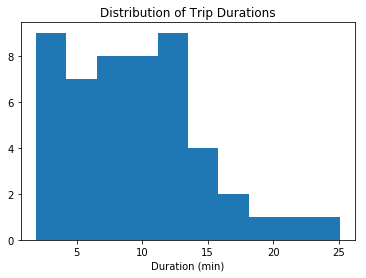

In [12]:
# load library
import matplotlib.pyplot as plt

# inline with the notebook.
%matplotlib inline 

# example histogram, data taken from bay area sample
data = [ 7.65,  8.92,  7.42,  5.50, 16.17,  4.20,  8.98,  9.62, 11.48, 14.33,
        19.02, 21.53,  3.90,  7.97,  2.62,  2.67,  3.08, 14.40, 12.90,  7.83,
        25.12,  8.30,  4.93, 12.43, 10.60,  6.17, 10.88,  4.78, 15.15,  3.53,
         9.43, 13.32, 11.72,  9.85,  5.22, 15.10,  3.95,  3.17,  8.78,  1.88,
         4.55, 12.68, 12.38,  9.78,  7.63,  6.45, 17.38, 11.90, 11.52,  8.63,]
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (min)')
plt.show()

In the above cell, we collected fifty trip times in a list, and passed this list as the first argument to the `.hist()` function. This function performs the computations and creates plotting objects for generating a histogram, but the plot is actually not rendered until the `.show()` function is executed. The `.title()` and `.xlabel()` functions provide some labeling for plot context.

You will now use these functions to create a histogram of the trip times for the city you selected in question 4c. Don't separate the Subscribers and Customers for now: just collect all of the trip times and plot them.

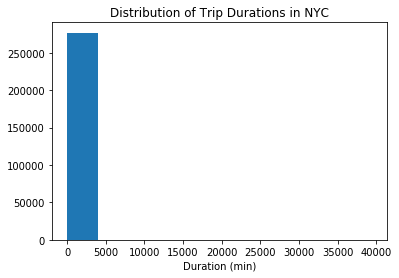

In [13]:
## collect all of the trip times as a list ##
## use pyplot functions to generate a histogram of trip times.     ##

durations = []
infile_csv = './data/NYC-2016-Summary.csv'

# read from input file
with open(infile_csv, 'r') as f_in:
    filereader = csv.DictReader(f_in)
    for row in filereader:
        durations.append(float(row['duration']))

plt.hist(durations)
plt.title('Distribution of Trip Durations in NYC')
plt.xlabel('Duration (min)')
plt.show()

If you followed the use of the `.hist()` and `.show()` functions exactly like in the example, you're probably looking at a plot that's completely unexpected. The plot consists of one extremely tall bar on the left, maybe a very short second bar, and a whole lot of empty space in the center and right. Take a look at the duration values on the x-axis. This suggests that there are some highly infrequent outliers in the data. Instead of reprocessing the data, you will use additional parameters with the `.hist()` function to limit the range of data that is plotted. Documentation for the function can be found [[here]](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist).

**Question 5**: Use the parameters of the `.hist()` function to plot the distribution of trip times for the Subscribers in your selected city. Do the same thing for only the Customers. Add limits to the plots so that only trips of duration less than 75 minutes are plotted. As a bonus, set the plots up so that bars are in five-minute wide intervals. For each group, where is the peak of each distribution? How would you describe the shape of each distribution?

**Answer**: In the following cell, data from NYC is plotted for both Customers and Subscribers into a single graph for better overview. Some observations:
- The distribution for customers and subscribers seemed to follow normal (aka Gaussian) distribution cruve. But right-skewed considering 75 minutes upper range cap.
- The peak for Subscribers is less than 10 minutes. Less than average trip length of 15.81 minutes of all users. (see answer 4b)
- The peak for Customers however is ~20 minutes. Higher than average trip length of 15.81 minutes for NYC.

**Reasoning:**
- one of the reason behind peak of Subscribers' at less than 10 minutes could be that, long term users usually use bikes as a primary mean of short distance commute. E.g. going to work, gym or super market. Such distances are well defined and often follows a starndard (and optimum) routes.
- for customer's or ad-hoc users, such as tourists or students, the bikes are used for longer routes and often unplanned or not as optimum as of the other user group.

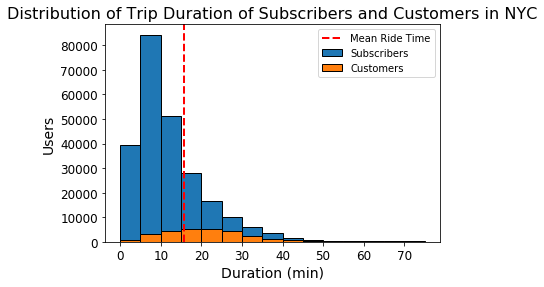

In [14]:
durations_sub = []
durations_cust = []
infile_csv = './data/NYC-2016-Summary.csv'
# recalling stats from 4
avg_ride_time, proportion_gt_30mins = trip_length_stat(infile_csv)

# read from input file
with open(infile_csv, 'r') as f_in:
    filereader = csv.DictReader(f_in)
    for row in filereader:
        if float(row['duration']) > 2: # rides shorter than 2 minutes are not taking into account for both user groups
            if row['user_type'] == 'Subscriber':
                durations_sub.append(float(row['duration']))
            else:
                durations_cust.append(float(row['duration']))

bins = [i for i in range(0,80,5)]
# adding range to histogram
plt.hist(durations_sub, bins,range=(0,75), label='Subscribers', edgecolor='k')
plt.hist(durations_cust, bins, range=(0,75), label='Customers', edgecolor='k')
plt.title('Distribution of Trip Duration of Subscribers and Customers in NYC', fontsize=16)
plt.xlabel('Duration (min)', fontsize=14)
plt.ylabel('Users', fontsize=14)
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)
# adds red dotted line indicating mean
plt.axvline(avg_ride_time, color='r', linestyle='dashed', linewidth=2, label='Mean Ride Time')
plt.legend()
plt.show()



<a id='eda_continued'></a>
## Performing Your Own Analysis

So far, you've performed an initial exploration into the data available. You have compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For one of these cities, you have investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. Now it is your turn to continue the exploration in a direction that you choose. Here are a few suggestions for questions to explore:

- How does ridership differ by month or season? Which month / season has the highest ridership? Does the ratio of Subscriber trips to Customer trips change depending on the month or season?
- Is the pattern of ridership different on the weekends versus weekdays? On what days are Subscribers most likely to use the system? What about Customers? Does the average duration of rides change depending on the day of the week?
- During what time of day is the system used the most? Is there a difference in usage patterns for Subscribers and Customers?

If any of the questions you posed in your answer to question 1 align with the bullet points above, this is a good opportunity to investigate one of them. As part of your investigation, you will need to create a visualization. If you want to create something other than a histogram, then you might want to consult the [Pyplot documentation](https://matplotlib.org/devdocs/api/pyplot_summary.html). In particular, if you are plotting values across a categorical variable (e.g. city, user type), a bar chart will be useful. The [documentation page for `.bar()`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.bar.html#matplotlib.pyplot.bar) includes links at the bottom of the page with examples for you to build off of for your own use.

**Question 6**: Continue the investigation by exploring another question that could be answered by the data available. Document the question you want to explore below. Your investigation should involve at least two variables and should compare at least two groups. You should also use at least one visualization as part of your explorations.

**Answer**: The following two cells contain exploration of monthly and weekly ridership in NYC respectively:  
**_Monthly_**:
+ Monthly total ridership closely follows normal distribution
+ Subscribers amount to greater contributor to rides.
+ Change in seasons amounts great variation in both user groups as well as total rides
+ Winter months sees less rides in general
+ As the summer months approaches Customers' share increases too
+ However, in July, the share of Subscribers is less compared to neighbouring months! Perhaps the locals go on vacation while city is flooded with tourists on bikes!!

**_Weekly_**:
+ Rides on weekly bases shows expected trends
+ Weekdays sees bigger share of rides as compared to weekends
+ However, the proportion of Customers using bikes on weekends is higher compared to Subscribers.

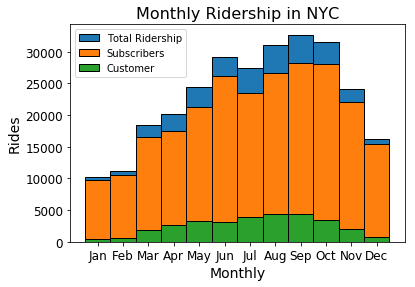

In [15]:
## Monthly distribution of riders in NYC

import calendar
import datetime

infile_csv = './data/NYC-2016-Summary.csv'

def read_from_csv(input_csvfile, duration=False, month=False, hour=False, day_of_week=False):
    """
    Function to create flexible stats for any column of the input csv file
    
    param: input --> csv file, column name: bool
    param: output --> tuple of lists containing 
                        1. all the values for desired column
                        2. all subscribers for desired column
                        3. all customers for desired column
    """
    # assign columns name
    if duration==True:
        col_name='duration'
    elif month==True:
        col_name='month'
    elif hour==True:
        col_name='hour'
    elif day_of_week==True:
        col_name='day_of_week'
    
    # init lists for output
    n_ridership4column = []
    n_ridership_sub = []
    n_ridership_cust = []
    
    with open(infile_csv, 'r') as f_in:
        filereader = csv.DictReader(f_in)
        for row in filereader:
            n_ridership4column.append(row[col_name])
            if row['user_type'] == 'Subscriber':
                n_ridership_sub.append(row[col_name])
            else:
                n_ridership_cust.append(row[col_name])
            
    return n_ridership4column, n_ridership_sub, n_ridership_cust

# using function above to get monthly ridership
monthwise = list(map(int, read_from_csv(infile_csv, month=True)[0]))
monthwise_sub = list(map(int, read_from_csv(infile_csv, month=True)[1]))
monthwise_cust = list(map(int, read_from_csv(infile_csv, month=True)[2]))

# plotting begins
## NOTE: Part of this solution was inspired by https://stackoverflow.com/questions/43283586/how-do-i-plot-a-histogram-of-months-with-dates-in-matplotlib
fig, ax = plt.subplots()
bins = [i for i in range(1,14)] # upper bound is 14 to accomodate bin for december

# Plotting monthly total along with customers and subscribers stacked
ax.hist(monthwise, bins=bins, edgecolor='k', align='left', label='Total Ridership', stacked= True)
ax.hist(monthwise_sub, bins=bins, edgecolor='k', align='left', label='Subscribers', stacked=True)
ax.hist(monthwise_cust, bins=bins, edgecolor='k', align='left', label='Customer', stacked=True)

ax.set_xticks(bins[:-1])
ax.set_xticklabels(list(calendar.month_abbr[i] for i in bins[:-1]))
## Below is an alternative that works too! but not so pretty workaround
# ax.set_xticklabels([datetime.date(1900,i,1).strftime('%b') for i in bins[:-1]]) 

plt.title('Monthly Ridership in NYC', fontsize=16)
plt.xlabel('Monthly', fontsize=14)
plt.ylabel('Rides', fontsize=14)
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)

plt.legend()
plt.show()



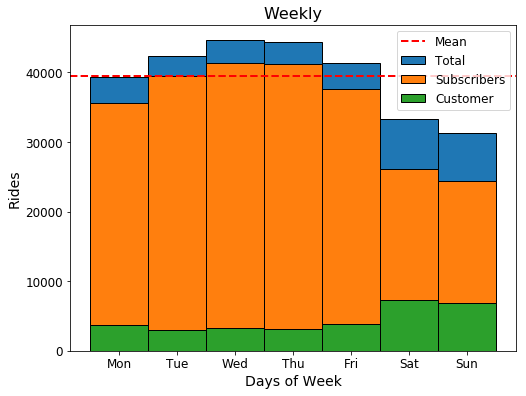

In [16]:
# using function above to get weekly ridership
weekwise = read_from_csv(infile_csv, day_of_week=True)[0]
weekwise_sub = read_from_csv(infile_csv, day_of_week=True)[1]
weekwise_cust = read_from_csv(infile_csv, day_of_week=True)[2]

# following is an ugly workaround to get days of the week on x-axis in the right order in the histogram.
# Logic is as following: 1. Just using python and matplotlib to get intended result avoiding pandas (don't ask why!!)
#                        2. simply by using plt.hist and the weekwise would not order the names in Mon-Sun sequence
#                        3. From names of days, get the index and then using ax.set_ticks giving it a right order

weekdays = [calendar.day_name[i] for i in range(7)]
weekly_avg = int(sum([weekwise.count(i) for i in weekdays]) / len(weekdays))
# print(weekly_avg)

fig, ax = plt.subplots(figsize=(8,6))
bins=[i for i in range(8)]

# Plotting total weekly rides, customer and subscribers stacked
ax.hist([weekdays.index(d) for d in weekwise],
        bins=bins, edgecolor='k', align='left', label='Total', stacked= True)
ax.hist([weekdays.index(d) for d in weekwise_sub], 
        bins=bins, edgecolor='k', align='left', label='Subscribers', stacked=True)
ax.hist([weekdays.index(d) for d in weekwise_cust], 
        bins=bins, edgecolor='k', align='left', label='Customer', stacked=True)

# Rename the xticks by first tagging them with bins and renaming that to Mon-Sun sequence by using weekdays list
ax.set_xticks(bins[:-1])
ax.set_xticklabels(list(calendar.day_abbr[i] for i in bins[:-1]))

plt.title('Weekly', fontsize=16)
plt.xlabel('Days of Week', fontsize=14)
plt.ylabel('Rides', fontsize=14)
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)
plt.axhline(weekly_avg, color='r', linestyle='dashed', linewidth=2, label='Mean')

plt.legend(fontsize=12)
plt.show()

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! This is only a sampling of the data analysis process: from generating questions, wrangling the data, and to exploring the data. Normally, at this point in the data analysis process, you might want to draw conclusions about the data by performing a statistical test or fitting the data to a model for making predictions. There are also a lot of potential analyses that could be performed on the data which are not possible with only the data provided. For example, detailed location data has not been investigated. Where are the most commonly used docks? What are the most common routes? As another example, weather has potential to have a large impact on daily ridership. How much is ridership impacted when there is rain or snow? Are subscribers or customers affected more by changes in weather?

**Question 7**: Putting the bike share data aside, think of a topic or field of interest where you would like to be able to apply the techniques of data science. What would you like to be able to learn from your chosen subject?

**Answer**: I would like to apply the techniques in geospatial field. e.g. Earth Observation and GIS data. Combined with remote sensing methods and CV, data science is a key to better object detection, crop analysis and natural disaster response.

In [17]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Bike_Share_Analysis.ipynb'])

0